In [25]:
# Basic import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Modelling

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import warnings


In [26]:
df=pd.read_csv('data\StudentsPerformance.csv')

<>:1: SyntaxWarning: invalid escape sequence '\S'
<>:1: SyntaxWarning: invalid escape sequence '\S'
C:\Users\USER\AppData\Local\Temp\ipykernel_13576\1292719692.py:1: SyntaxWarning: invalid escape sequence '\S'
  df=pd.read_csv('data\StudentsPerformance.csv')


In [27]:
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [28]:
import re
df.columns = [re.sub(r'[^0-9a-zA-Z_]+', '_', c.strip().lower()) for c in df.columns]

In [29]:
df.head()

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


Preparing X and Y variables

In [30]:
target='math_score'

In [31]:
x=df.drop(columns=[target], axis=1)

In [32]:
y=df[target]

In [33]:
x.head()

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,reading_score,writing_score
0,female,group B,bachelor's degree,standard,none,72,74
1,female,group C,some college,standard,completed,90,88
2,female,group B,master's degree,standard,none,95,93
3,male,group A,associate's degree,free/reduced,none,57,44
4,male,group C,some college,standard,none,78,75


In [34]:
cat_features=x.select_dtypes(include="object").columns
print(cat_features)

Index(['gender', 'race_ethnicity', 'parental_level_of_education', 'lunch',
       'test_preparation_course'],
      dtype='object')


1. What is a ColumnTransformer?

A ColumnTransformer is a tool in scikit-learn that lets you apply different preprocessing steps to different columns of a dataset in a single step.

Some columns need scaling (numeric)
Some columns need encoding (categorical)
Some columns may need imputation (filling missing values)

Instead of doing each separately, ColumnTransformer does it all together and outputs a ready-to-use dataset for machine learning.

2. Why is it used?

Machine learning models require all input features to be numeric.
But real datasets often have mixed data types: numeric + categorical
And different types require different preprocessing
ColumnTransformer solves this problem:

It applies the right transformer to the right columns
Outputs a single array or DataFrame ready for the mode

In [35]:
df.columns

Index(['gender', 'race_ethnicity', 'parental_level_of_education', 'lunch',
       'test_preparation_course', 'math_score', 'reading_score',
       'writing_score'],
      dtype='object')

In [36]:
# separate dataset into train and test

from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)
x_train.shape, x_test.shape

((800, 7), (200, 7))

In [37]:
#create column type transformer with 3 types of transformers

num_features=x.select_dtypes(exclude="object").columns
cat_features=x.select_dtypes(include="object").columns

from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.compose import ColumnTransformer

numeric_transformer=StandardScaler()
oh_transformer=OneHotEncoder()

#pipeline -> preprocessor
preprocessor=ColumnTransformer(
    [
        ("OneHotEncoder",oh_transformer,cat_features),
        ("StanderedScaler", numeric_transformer,num_features)
    ]
)


In [38]:
X_train_processed = preprocessor.fit_transform(x_train)
X_test_processed = preprocessor.transform(x_test)
# You use fit_transform() only on the "training data", because:
# You want to learn the parameters (mean, std, categories) from the training set
# Then apply the transformation to the same data

In [47]:
X_train_processed

array([[ 1.        ,  0.        ,  0.        , ...,  1.        ,
         0.03079054,  0.43405338],
       [ 1.        ,  0.        ,  0.        , ...,  0.        ,
         0.9302895 ,  0.96470125],
       [ 1.        ,  0.        ,  0.        , ...,  1.        ,
         1.34544287,  1.1636942 ],
       ...,
       [ 1.        ,  0.        ,  0.        , ...,  1.        ,
        -0.52274728, -1.02522827],
       [ 0.        ,  1.        ,  0.        , ...,  0.        ,
        -1.49143847, -1.02522827],
       [ 1.        ,  0.        ,  0.        , ...,  1.        ,
         1.48382733,  1.36268716]], shape=(800, 19))

Create an Evaluate Function to give all metrics after model Training

In [40]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

In [41]:
# variable = list(dictionary.values())[index]-->model=list(models.values())[i]
# Breakdown:
# dictionary.values() - returns a view of all values in the dictionary
# list() - converts the view to a list
# [index] - accesses the element at the specified position


# In Python, the () parentheses are used for both:
# Function calls: function_name()
# Object instantiation: ClassName()
"""class Person:
    def __init__(self, name):
        self.name = name

# Object instantiation  
person = Person("Bob")
__________________________
What happens:
Python finds the class Person
Creates a new instance (allocates memory)
Calls __init__ method to initialize the object
Returns the new object

The name person now holds the object reference



When we write LinearRegression(), Python creates an object of the LinearRegression class
Each object can now:
Be trained (fit)
Make predictions (predict)
Access model-specific attributes (like coefficients)
"""

'class Person:\n    def __init__(self, name):\n        self.name = name\n\n# Object instantiation  \nperson = Person("Bob")\n__________________________\nWhat happens:\nPython finds the class Person\nCreates a new instance (allocates memory)\nCalls __init__ method to initialize the object\nReturns the new object\n\nThe name person now holds the object reference\n\n\n\nWhen we write LinearRegression(), Python creates an object of the LinearRegression class\nEach object can now:\nBe trained (fit)\nMake predictions (predict)\nAccess model-specific attributes (like coefficients)\n'

In [42]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(),
    "CatBoosting Regressor": CatBoostRegressor(verbose=False),
    "AdaBoost Regressor": AdaBoostRegressor()
}

model_list = []
r2_list = []

for name, model in models.items():
    # Train
    model.fit(X_train_processed, y_train)
    
    # Predict
    y_train_pred = model.predict(X_train_processed)
    y_test_pred = model.predict(X_test_processed)
    
    # Evaluate
    train_mae, train_rmse, train_r2 = evaluate_model(y_train, y_train_pred)
    test_mae, test_rmse, test_r2 = evaluate_model(y_test, y_test_pred)
    
    # Store results
    model_list.append(name)
    r2_list.append(test_r2)
    
    # Print results
    print(name)
    print("Train RMSE: {:.4f}, MAE: {:.4f}, R2: {:.4f}".format(train_rmse, train_mae, train_r2))
    print("Test RMSE: {:.4f}, MAE: {:.4f}, R2: {:.4f}".format(test_rmse, test_mae, test_r2))
    print("="*40)


Linear Regression
Train RMSE: 5.3231, MAE: 4.2667, R2: 0.8743
Test RMSE: 5.3940, MAE: 4.2148, R2: 0.8804
Lasso
Train RMSE: 6.5925, MAE: 5.2053, R2: 0.8072
Test RMSE: 6.5173, MAE: 5.1557, R2: 0.8254
Ridge
Train RMSE: 5.3233, MAE: 4.2650, R2: 0.8743
Test RMSE: 5.3904, MAE: 4.2111, R2: 0.8806
K-Neighbors Regressor
Train RMSE: 5.6974, MAE: 4.5042, R2: 0.8560
Test RMSE: 7.2172, MAE: 5.5880, R2: 0.7859
Decision Tree
Train RMSE: 0.2795, MAE: 0.0187, R2: 0.9997
Test RMSE: 7.6469, MAE: 6.1250, R2: 0.7597
Random Forest Regressor
Train RMSE: 2.2947, MAE: 1.8287, R2: 0.9766
Test RMSE: 5.9934, MAE: 4.6260, R2: 0.8524
XGBRegressor
Train RMSE: 1.0073, MAE: 0.6875, R2: 0.9955
Test RMSE: 6.4733, MAE: 5.0577, R2: 0.8278
CatBoosting Regressor
Train RMSE: 3.0427, MAE: 2.4054, R2: 0.9589
Test RMSE: 6.0046, MAE: 4.6088, R2: 0.8518
AdaBoost Regressor
Train RMSE: 5.8782, MAE: 4.7894, R2: 0.8467
Test RMSE: 6.1688, MAE: 4.7953, R2: 0.8436


In [ ]:
list(models.keys())


'tthre'

In [43]:
pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model Name', 'R2_Score']).sort_values(by=["R2_Score"],ascending=False)

,Model Name,R2_Score
2,Ridge,0.880592
0,Linear Regression,0.880433
5,Random Forest Regressor,0.852382
7,CatBoosting Regressor,0.851831
8,AdaBoost Regressor,0.843616
6,XGBRegressor,0.827797
1,Lasso,0.825446
3,K-Neighbors Regressor,0.785944
4,Decision Tree,0.759697


In [44]:
lin_model = LinearRegression(fit_intercept=True)
lin_model.fit(X_train_processed, y_train)
y_pred = lin_model.predict(X_test_processed)

score = r2_score(y_test, y_pred) * 100
print("Linear Regression Accuracy: {:.2f}%".format(score))

Linear Regression Accuracy: 88.04%


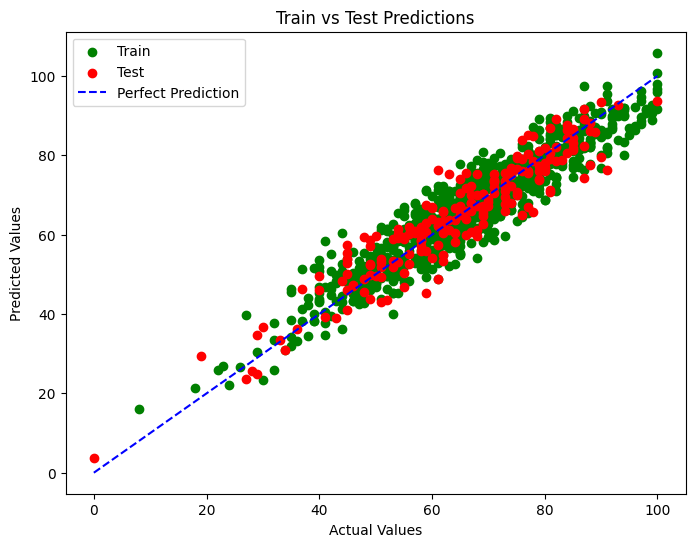

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))

# Training set predictions
plt.scatter(y_train, lin_model.predict(X_train_processed), color='green', label='Train')

# Test set predictions
plt.scatter(y_test, lin_model.predict(X_test_processed), color='red', label='Test')

# Perfect prediction line
min_val = min(y_train.min(), y_test.min())
max_val = max(y_train.max(), y_test.max())
plt.plot([min_val, max_val], [min_val, max_val], color='blue', linestyle='--', label='Perfect Prediction')

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Train vs Test Predictions')
plt.legend()
plt.show()




Difference between Actual and Predicted Values

In [46]:
import pandas as pd

# Create DataFrame to compare actual vs predicted
pred_df = pd.DataFrame({
    'Actual Value': y_test,
    'Predicted Value': lin_model.predict(X_test_processed),
    'Difference': y_test - lin_model.predict(X_test_processed)
})

pred_df.head()  # display top rows


,Actual Value,Predicted Value,Difference
521,91,76.387970,14.612030
737,53,58.885970,-5.885970
740,80,76.990265,3.009735
660,74,76.851804,-2.851804
411,84,87.627378,-3.627378
